# Makemore (Part 3)

## Review

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('/media/eric/D/datasets/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [7]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1+ b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.9417
  20000/ 200000: 2.5795
  30000/ 200000: 2.7819
  40000/ 200000: 2.0216
  50000/ 200000: 2.5858
  60000/ 200000: 2.3217
  70000/ 200000: 2.1007
  80000/ 200000: 2.2893
  90000/ 200000: 2.2368
 100000/ 200000: 1.9774
 110000/ 200000: 2.4507
 120000/ 200000: 1.9623
 130000/ 200000: 2.3657
 140000/ 200000: 2.2424
 150000/ 200000: 2.1469
 160000/ 200000: 2.2506
 170000/ 200000: 1.7543
 180000/ 200000: 2.1055
 190000/ 200000: 1.8174


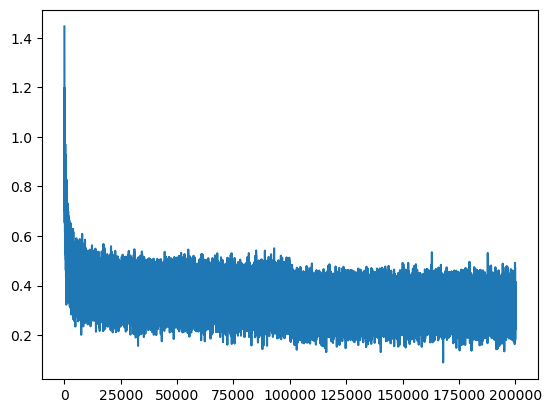

In [8]:
plt.plot(lossi)

In [9]:
@torch.no_grad() # this decorator on the function disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.126697540283203
val 2.171041250228882


In [10]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1) # concatenate the vectors
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

mona.
mayah.
see.
mel.
ryllo.
emmadiengramira.
eredielin.
shy.
jen.
eden.
eson.
arleiyah.
hone.
cayshubergihimier.
kendreelynn.
nochorius.
macder.
yaque.
ehs.
kayjahsin.


## Improving network initialization configuration
Currently, our neural net has a bad initialization configuration. Here are some problems we can see:

### 1. The initial loss is too high
We can see that in the first iteration, before any weight update, we have a loss of ~27, which is too high. Normally, in neural networks, knowing the problem and the loss function, we can expect what the initial loss should be. For example, in our case, for what comes out of the network we would initially expect an uniform distribution (equal probability to each of the 27 characters), so 1/27 each:

In [11]:
expected_loss = -torch.tensor(1/27.0).log()
expected_loss.item()

3.295836925506592

The reason we are getting a much higher loss (27) is because for the logits, that potentially indicate the classes, as there is only 1 correct class, it is less likely that the one corresponding to the correct class has a high value, than the others wrongly have a high value. So some others having extreme values will make the loss increase a lot. See this example:  

If all logits are equal (in this case 0.0 but could be any other), softmax will be equally distributed (same confidence for all classes) and loss will be as expected:

In [12]:
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = F.softmax(logits, dim=0)
loss = -probs[2].log() # 2 is the correct class
expected_loss = -torch.tensor(1/4.0).log()
probs, loss, expected_loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863), tensor(1.3863))

The following is possible, and would decrease the loss:

In [13]:
logits = torch.tensor([0.0, 0.0, 5.0, 0.0]) # by chance, class 2 is correctly confident
probs = F.softmax(logits, dim=0)
loss = -probs[2].log() # 2 is the correct class
expected_loss = -torch.tensor(1/4.0).log()
probs, loss, expected_loss

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(0.0200), tensor(1.3863))

But more likely is the following, that would increase it:

In [14]:
logits = torch.tensor([-2.0, 6.0, 2.0, 3.0]) # by chance, class 1 is overconfidently wrong
probs = F.softmax(logits, dim=0)
loss = -probs[2].log() # 2 is the correct class
expected_loss = -torch.tensor(1/4.0).log()
probs, loss, expected_loss

(tensor([3.1397e-04, 9.3595e-01, 1.7142e-02, 4.6598e-02]),
 tensor(4.0662),
 tensor(1.3863))

So now we will solve this. First we will modify the parameters that directly influence the logits: `W2` and `b2`, and make them near to 0:

In [15]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # better not to set weight to 0
b2 = torch.randn(vocab_size,                      generator=g) * 0 # we can set bias to 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [16]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1+ b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    if i == 0:
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}, and we expected 3.2958')
    else:
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3221, and we expected 3.2958


  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8645
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


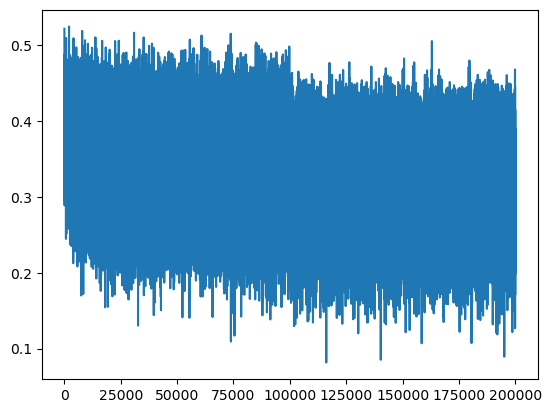

In [17]:
plt.plot(lossi)

As we can see, this time the initial loss is more correct, and in the plot we see that we don't have that long tail, that was the "easy" part for the network to optimize the weights at the beggining (the logits (and weights) were being squashed down). Instead, now we are only getting the "hard gains" of training the neural net, and we are not wasting time squashing down the weights, but more time really oprimizing them.

In [18]:
split_loss('train')
split_loss('val')

train 2.069589138031006
val 2.1310744285583496


### The output `h` after the first hidden layer has too many -1.0 and +1.0 
Next, we want to modify the initialization of the parameters that affect `h`: 

In [19]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # better not to set weight to 0
b2 = torch.randn(vocab_size,                      generator=g) * 0 # we can set bias to 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [20]:
# same optimization as last time
max_steps = 1
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1+ b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    if i == 0:
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}, and we expected 3.2958')
    else:
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/      1: 3.3221, and we expected 3.2958


In [21]:
h

tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
        [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
        [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
        ...,
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)

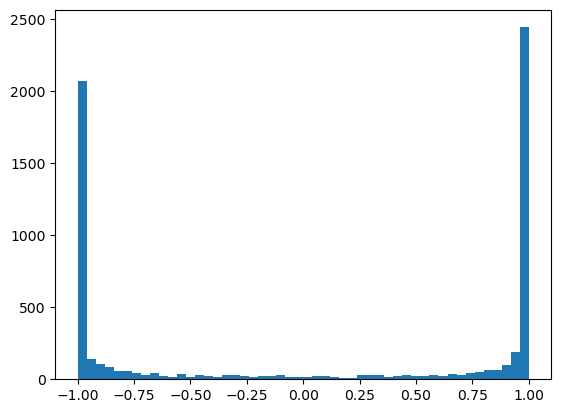

In [45]:
plt.hist(h.view(-1).tolist(), 50);

**IMPORTANT**: As we can see, it has too many -1.0 and +1.0, because of the activation function **tanh**. And this is very bad, because, as we remember, the formula for the backpropagation of tanh was: `self.grad += (1 - t**2) * out.grad`, so if `t` (the output of tanh, our `h`) is -1.0 or +1.0, the input gradient would be multiplied by 0 and canceled, so the modification of the gradient for that parameter would be 0. Which makes sense, the tanh function at its tails is very flat, so an input change there can be insignificant for the output. So in those cases, the gradient would not flow throgh the network and would be destroyed at this layer. But if `t` is 0.0, the tanh unit is inactive and the gradient will pass through. So, because of the formula, the gradient passing through tanh can only decrease, and the amount it decreases is proportional to how far it is from 0 (how far it goes to the tails).

torch.Size([32, 200])

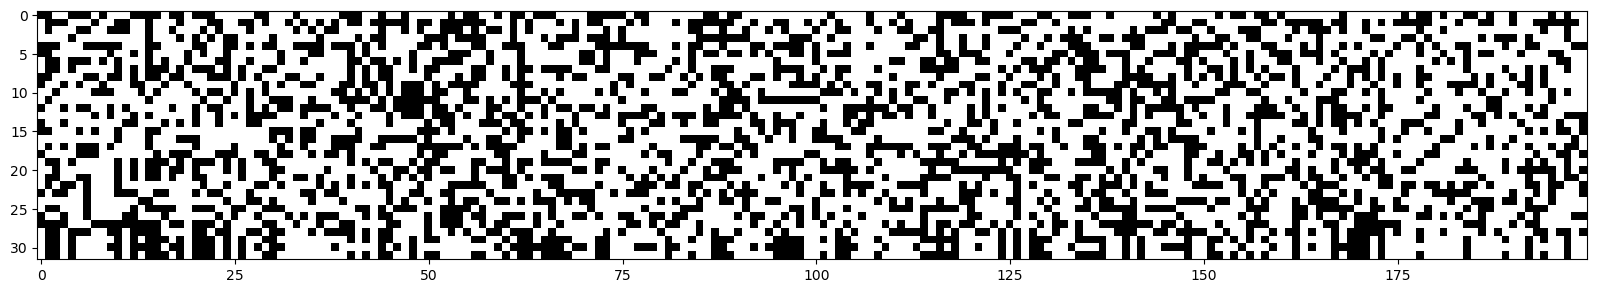

In [24]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest") # white is True, black is False
h.shape # 200 neurons, 32 examples

As we can see, there are many white regions, which means those neurons are very active and the backward gradient is being destroyed when passing through them. We would be in a trouble if any of the 200 columns is completely white, then we would have a "**dead neuron**", where the initialization of the weights and the biases was such that no single example ever activates this tanh, so all examples would be landing on the tails.  
However, this is not the case in our problem, and we see some examples activate the neuron while others don't (so sometimes is learning and others not).  
This can happen to other activation functions too (sigmoid, ReLU...). In the case of ReLU, if the preactivation is negative, it will be zeroing out the gradient during backpropagation. This can happen at initialization, where the neuron would be dead forever (its weigths and biases would never change), and this happens by chance, because of how weights and biases were initialized. But it can also happen during optimization, where they can get a by chance a high gradient that knocks them off, and nothing will ever activate them again, so they are dead (like permanent brain damage). Leaky ReLU doesn't suffer from this problem that much, but ELU can, it also has flat regions.

So, even if we are not getting any dead neuron and our network is still learning, it is not optimal that at initialization we get so many white regions.  
To solve it, we want the preactivation to be closer to 0. So we have `hpreact = embcat @ W1 + b1`, and embcat comes from `C`, so it's uniform gaussian. So we want to set W1 and b1 closer to 0.0:

In [40]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # could be 0.0, but a bit of entropy can be helpful
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [41]:
# same optimization as last time
max_steps = 1
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1+ b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    if i == 0:
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}, and we expected 3.2958')
    else:
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/      1: 3.3135, and we expected 3.2958


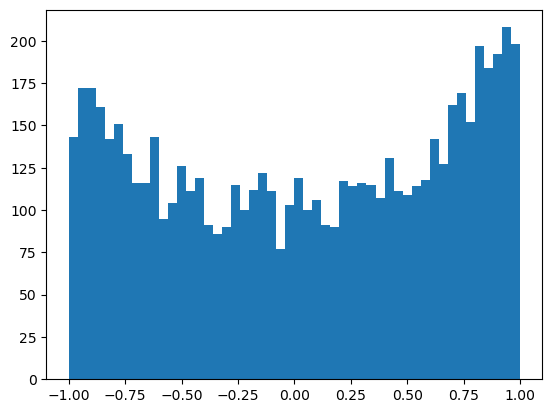

In [42]:
plt.hist(h.view(-1).tolist(), 50);

This is how the distribution should look like. So `W1 * 0.2` was a decent initialization. `0.1` was getting more of a normal distribution, which is not bad, but we prefer this other distribution.

torch.Size([32, 200])

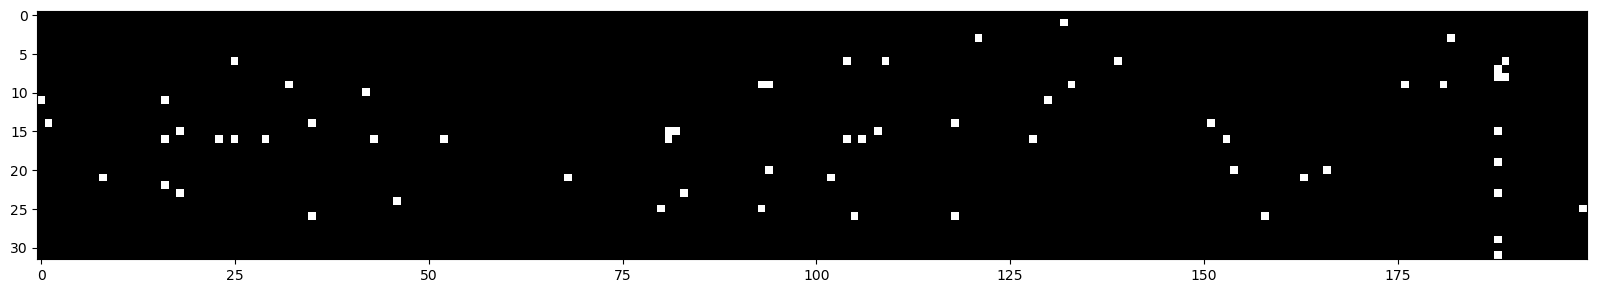

In [43]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest") # white is True, black is False
h.shape # 200 neurons, 32 examples

Now let's run the full optimization:

In [44]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # could be 0.0, but a bit of entropy can be helpful
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [45]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1+ b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    if i == 0:
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}, and we expected 3.2958')
    else:
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3135, and we expected 3.2958
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


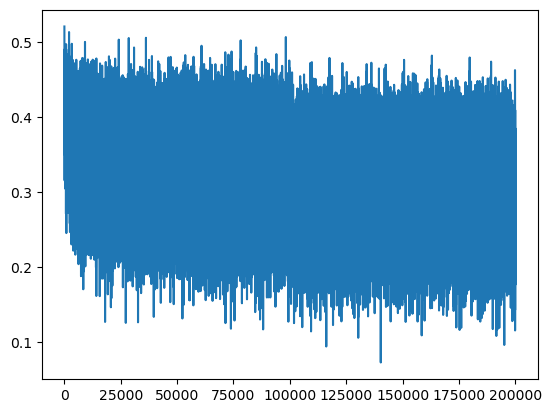

In [46]:
plt.plot(lossi)

In [47]:
split_loss('train')
split_loss('val')

train 2.0355963706970215
val 2.1026782989501953


### Summary of losses after each improvement
**loss log**
- original:  
train `2.12` val `2.16`

- fix softmax confidently wrong:  
train `2.07` val `2.13`

- fix tanh layer too saturated at init:  
train `2.03` val `2.10`

With a shallow network (1 layer) like ours, even with a bad initialization, it was able to eventually learn, and solving the problems didn't improve much the performance. But with deeper networks (like 50 layers), these problems would stack up and then it will be relevant.

Also, actually the scales we used to multiply the parameters at initialization (0.2, 0.01...) are not set by hand, there are some principles to set them.

tensor(0.0127) tensor(0.9988)
tensor(0.0064) tensor(3.1460)


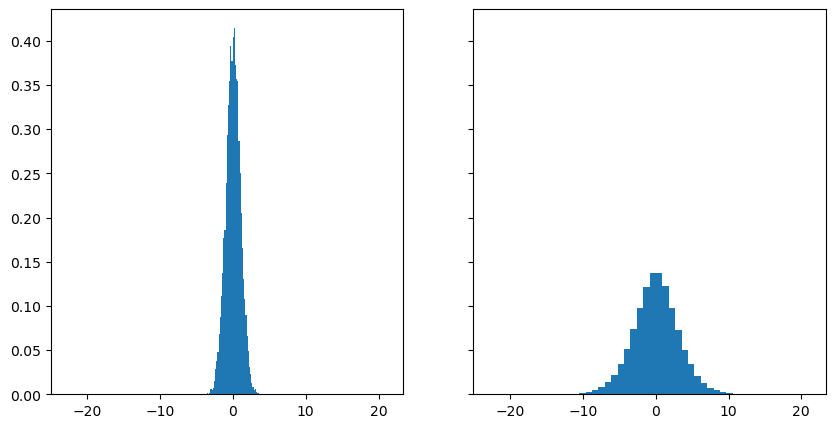

In [9]:
x = torch.randn(1000, 10) # drawn from a gaussian
w = torch.randn(10, 200) # drawn from a gaussian
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].hist(x.view(-1).tolist(), 50, density=True)
ax[1].hist(y.view(-1).tolist(), 50, density=True);

As we can see, `x` has initially a std of ~1.0, but after multiplying with `w`, the distribution of `y` gets wider. But we don't want that, we want all of the neural nets to have relatively similar activations. So, we need to determine by how do we have to multiply `w` so that its std remains 1.0.  
One way to do it is to divide by the square root of the "fan-in" (number of weights that flow into the neuron): 

tensor(-0.0193) tensor(0.9976)
tensor(-0.0027) tensor(0.9843)


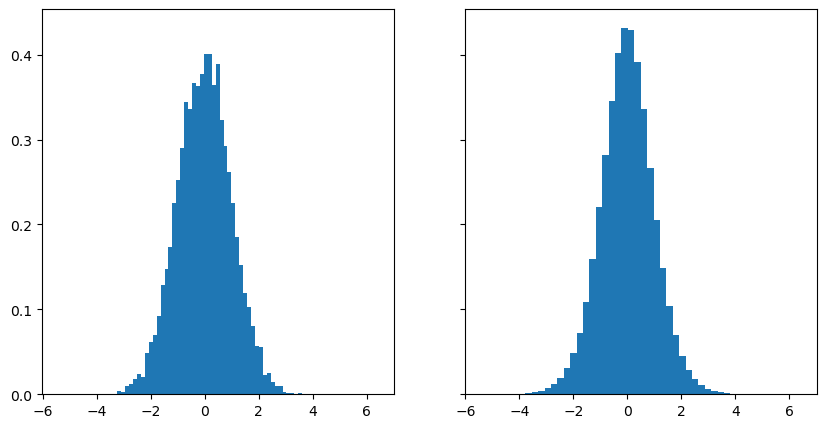

In [10]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].hist(x.view(-1).tolist(), 50, density=True)
ax[1].hist(y.view(-1).tolist(), 50, density=True);

A better way is to divide it by the **square root of 2/fan-in** (this initialization is called the [Kaiming initialization](https://arxiv.org/abs/1502.01852)). This was investigated in a paper with the ReLU, where negative numbers are zeroed-out which means half of the distribution is discarded, that's why the 2. But this can also apply to other activation functions like our tanh.  
In pytorch, there is a function for that. The mode says if we want to normalize the fan-in or the fan-out, and as the paper prooved that doesn't matter, the default is fan-in. The nonlinearity is used to [determine the "gain"](https://pytorch.org/docs/stable/nn.init.html).  
The gain is important because the activation function squashes the distribution (e.g. ReLU does it by discarding half of it), and to fight the squeeze in, we need to boost the weights a little bit, so that we renormalize back to a std=1.0.

In [ ]:
torch.nn.init.kaiming_normal_(mode="fan_in", nonlinearity="leaky_relu")

Some years ago, deep neural nets were very fragile to initialization, so this things were very relevant. But nowadays there are techniques that make them more stable (batch normalization, adam optimization...). So normally, we can simply initialize them by the square root of the fan-in.  
For now, we will use Kaiming initialization: **std = gain / square root of fan-in**.

In [12]:
(torch.randn(10000) * 0.2).std() # as we can see, the number we multply ends up being the std

tensor(0.2029)

In [13]:
# W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
# fan-in = n_embd * block_size = 10 * 3 = 30
(5/3) / (30**0.5) # for tanh, gain = 5/3

0.3042903097250923

In [6]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / (n_embd * block_size)**0.5
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


## Batch normalization
[paper here](https://arxiv.org/abs/1502.03167)  
We can just normalize (standardize) the preactivations after each layer. But we don't want to have always unit standard distributions for all neurons, it would be useful for some of them to be shifted right or left. So, in addition to normalization, we will also **scale by a gain** and **shift by a bias**.  
We will usually put normalization layers after layers that involve products (like linear layers or convolutions).

In [7]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / (n_embd * block_size)**0.5
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12297


In [8]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1+ b1 # hidden layer pre-activation
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # batch normalization
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    if i == 0:
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}, and we expected 3.2958')
    else:
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3147, and we expected 3.2958
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


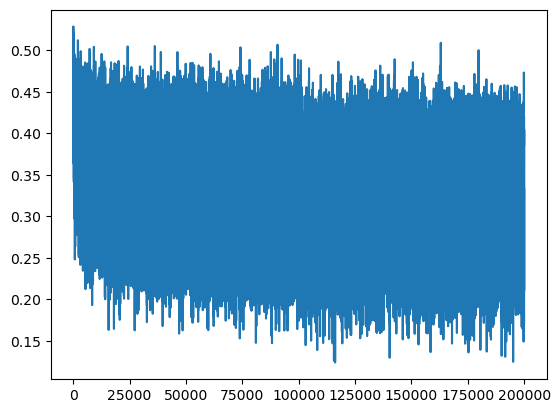

In [9]:
plt.plot(lossi)

In [10]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # batch normalization
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.104844808578491


But now, we realize that the output of a neuron for one example is not a function of only that example, but a function that includes all the examples in the batch (that were selected randomly). Because of that, we will get some jitter on `h` and on the `logits`. And this is actually good, because, as a side effect, it introduces a bit of entropy and acts as a regularizer, reducing overfitting.  
However, people don't like that the examples in a batch are coupled mathematically in the forward pass, as it can produces strange results. So they have tryed to abbandon batch normalization and move to other normalization techniques (layer normalization, instance normalization...), but it's hard because it still works very good.

So, if the network expects batches as an input (is estimating the mean and std for a batch at the forward pass), and at inference time we want to pass a single example, we can compute the batch normalization mean and std a single time after training, and use it at inference:

In [11]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set a single time
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [12]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.066890239715576
val 2.1049015522003174


However, we don't want to estimate `bnmean` and `bnstd` after training. Instead, we can do it during training:

In [13]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / (n_embd * block_size)**0.5
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12297


In [14]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1+ b1 # hidden layer pre-activation
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # batch normalization

  with torch.no_grad(): # we make sure this is not included in the gradient computation graph
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    if i == 0:
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}, and we expected 3.2958')
    else:
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3147, and we expected 3.2958
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


Now, instead of two separate stages, they are computed aside of each other.

In [15]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.1050572395324707


We also realize that the bias `b1` is being useless, because later we are substracting the std. We confirm it by looking at their gradients, they are 0:

In [19]:
b1.grad[:10]

tensor([-1.3970e-09,  4.6566e-10, -1.1642e-09, -1.2806e-09, -1.1642e-09,
         4.6566e-10,  1.8626e-09,  2.3283e-09, -2.3283e-09,  1.8626e-09])

So we can delete it, as now we already have `bnbias` in charge of biasing the distribution:

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / (n_embd * block_size)**0.5
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

**Conclusion**: try to avoid batch normalization layer, as said before, it can cause many bugs. Try other normalization techniques.

### Summary of losses after each improvement
**loss log**
- original:  
train `2.12` val `2.16`

- fix softmax confidently wrong:  
train `2.07` val `2.13`

- fix tanh layer too saturated at init:  
train `2.03` val `2.10`

- use semi-principled "kaiming init" instead of hacky init:  
train `2.03` val `2.10`

- add batch norm layer:  
train `2.06` val `2.10`

## Summary. Defining pytorchic classes

In [52]:
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  # layers[-1].weight *= 0.1 # this was done before batch norm
  layers[-1].gamma *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [53]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


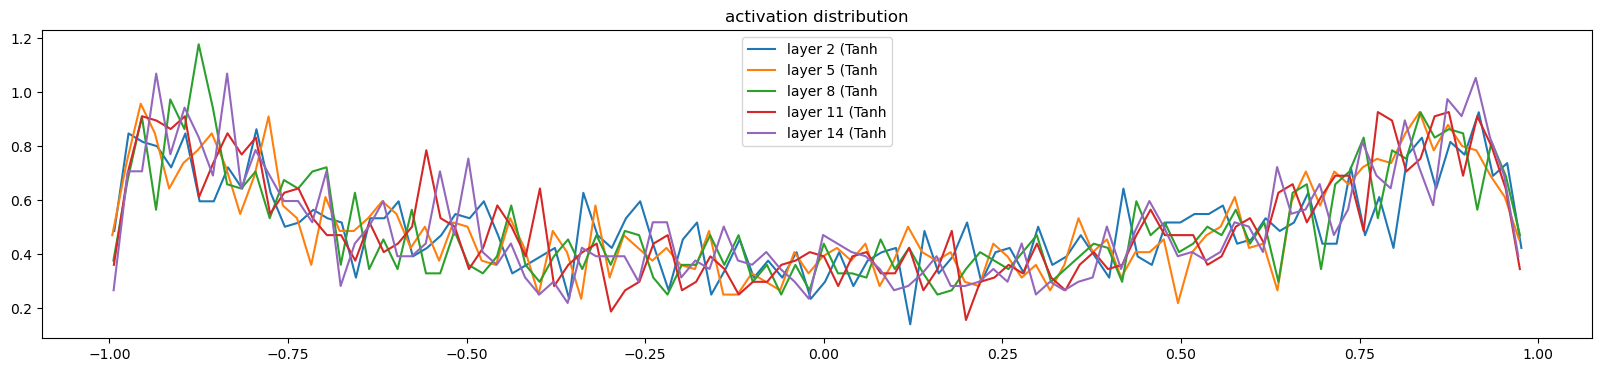

In [54]:
# histogram of preactivations before each Tanh layer

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution');

Saturation indicate how much at the tails is the preactivation.

layer 2 (      Tanh): mean +0.000000, std 3.682957e-03
layer 5 (      Tanh): mean +0.000000, std 3.262610e-03
layer 8 (      Tanh): mean -0.000000, std 2.973731e-03
layer 11 (      Tanh): mean +0.000000, std 2.741112e-03
layer 14 (      Tanh): mean -0.000000, std 2.584294e-03


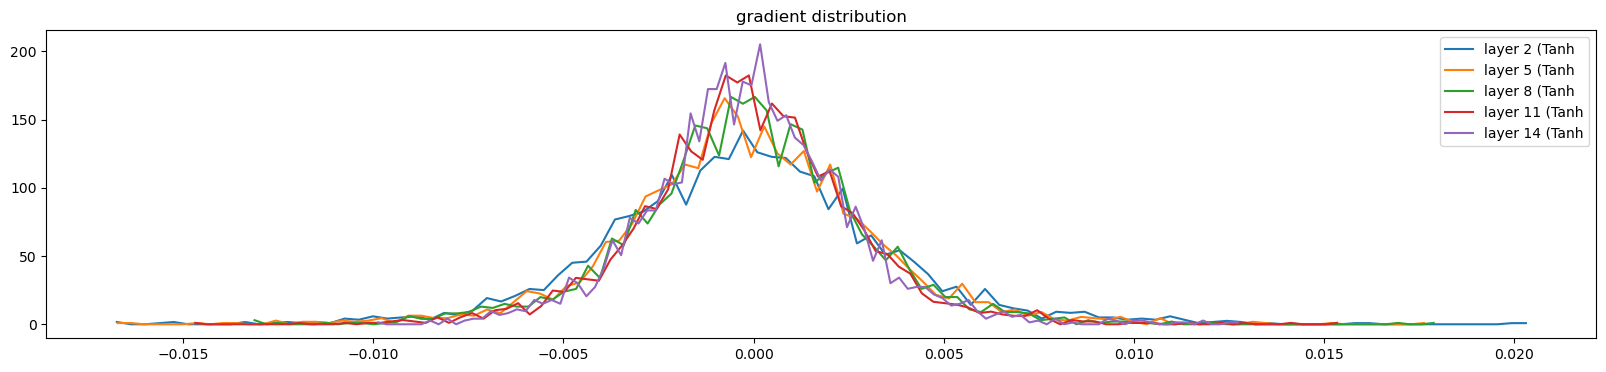

In [55]:
# histogram of gradients for each Tanh layer

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution');

weight   (27, 10) | mean -0.000000 | std 1.019887e-02 | grad:data ratio 1.018848e-02
weight  (30, 100) | mean +0.000092 | std 8.238436e-03 | grad:data ratio 2.635841e-02
weight (100, 100) | mean +0.000031 | std 7.318117e-03 | grad:data ratio 4.377148e-02
weight (100, 100) | mean -0.000019 | std 6.662026e-03 | grad:data ratio 3.949897e-02
weight (100, 100) | mean -0.000019 | std 5.821518e-03 | grad:data ratio 3.468162e-02
weight (100, 100) | mean +0.000053 | std 5.445300e-03 | grad:data ratio 3.243370e-02
weight  (100, 27) | mean -0.000165 | std 1.046845e-02 | grad:data ratio 6.281268e-02


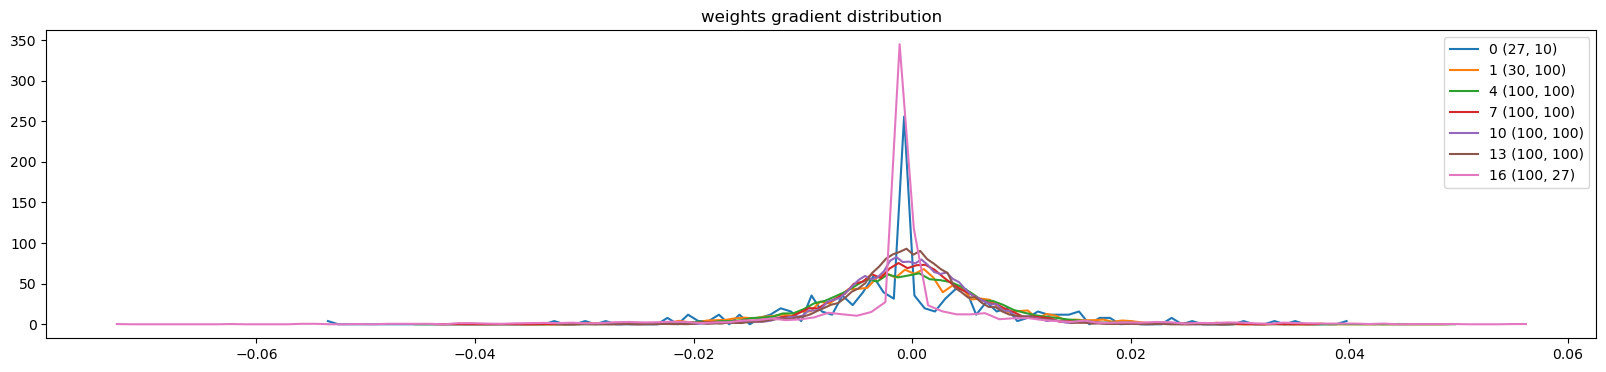

In [56]:
# histogram of the distribution of weights
# important to check it every time we train neural networks

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

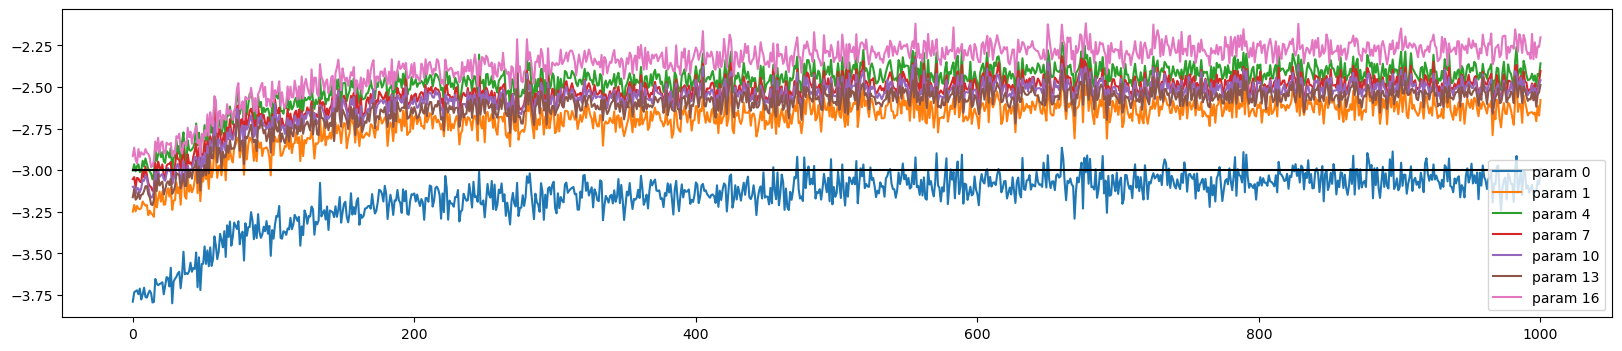

In [57]:
# plot of the update (learning) ratios of the parameters (weights) (y-axis is log10)

plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

#### (before batch norm) The pink one (param 11) is an outlier because we artificially made the last layer less confident 
#### by multiplying its weights by 0.1.  
# If the update ratios are below the line 1e-3, the parameters are not trained fast enough. 

**IMPORTANT**: the reason we use activation functions is because, if not, we would have a lot of linear layers stacked, which is equivalent to a big linear operation. So no matter how many layers you would stack, it would only be a linear transformation. With activation functions we introduce non-linearity.